# Term Project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import climlab

In [2]:
# CONFIGURE DOMAIN
N_lat = 90 # number of latitude points
N_lev = 50 # number of vertical levels

# PRESCRIBE BOUNDARY CONDITIONS
d_ml = 5. # mixed layer depth used to calculate surface heat capacity [m]
RH_surf = 0.8 # surface relative humidity [unitless]

# CONFIGURE CONVECTION SCHEME
conv_scheme = 'MALR' # hard adjustment convection scheme [MALR, DALR, or set custom lapse rate]

# CONFIGURE RADIATION SCHEME
day_of_year = 80. # use insolation at equinox [days after Jan 1]

## Annual mean RCE

In [3]:
# initialize state with mixed layer depth d_ml
state_dml = climlab.column_state(num_lev=N_lev, num_lat=N_lat, water_depth=d_ml)

In [4]:
# construct the RCE model
rce = climlab.TimeDependentProcess(state=state_dml)
h2o = climlab.radiation.ManabeWaterVapor(state=state_dml)
conv = climlab.convection.ConvectiveAdjustment(state={'Tatm':rce.state['Tatm']}, adj_lapse_rate=6.5, **rce.param)
sol = climlab.radiation.DailyInsolation(domains=rce.Ts.domain)
rad = climlab.radiation.RRTMG(state=state_dml, insolation=sol.insolation, specific_humidity=h2o.q, coszen=sol.coszen)
rce.add_subprocess('radiation', rad)
rce.add_subprocess('insolation', sol)
rce.add_subprocess('water', h2o)
rce.add_subprocess('convection', conv)

Data retrieved from http://thredds.atmos.albany.edu:8080/thredds/fileServer/CLIMLAB/ozone/apeozone_cam3_5_54.nc and saved locally.


C:\Users\omiyawaki\anaconda3\envs\geos24600\lib\site-packages\climlab\radiation\radiation.py:156: UserWarning: Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.
  warnings.warn('Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.')
C:\Users\omiyawaki\anaconda3\envs\geos24600\lib\site-packages\climlab\radiation\radiation.py:163: UserWarning: Interpolation of ozone data failed. Setting O3 to zero instead.
  warnings.warn('Interpolation of ozone data failed. Setting O3 to zero instead.')


In [5]:
[mesh_lat, mesh_lev] = np.meshgrid(rce.lat, rce.lev, indexing='ij')

The initial temperature profile looks as follows.

In [6]:
def tatm_lat_lev(model):
    plt.figure()
    plt.contourf(mesh_lat, mesh_lev, model.Tatm, cmap=plt.cm.coolwarm)
    plt.xlabel('Latitude (deg)')
    plt.ylabel('Pressure (hPa)')
    plt.colorbar(label='Temperature (K)')
    plt.gca().invert_yaxis()
    plt.show()

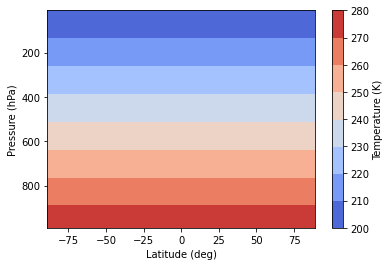

In [7]:
tatm_lat_lev(rce)

Let's let the model integrate for a year and check the temperature profile.

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9993368783782377 years.


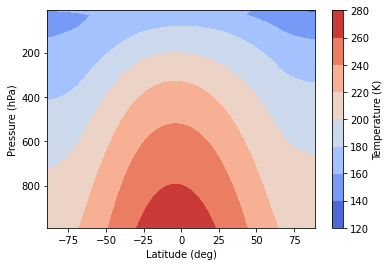

In [8]:
rce.integrate_years(1.)
tatm_lat_lev(rce)

The current model doesn't include large-scale dynamics so there is a large meridional temperature gradient. Let's run the model for another year to see if it is equilibrated.

In [ ]:
rce.integrate_years(1)
tatm_lat_lev(rce)

Integrating for 365 steps, 365.2422 days, or 1 years.


The upper troposphere appears to have warmed slightly. Let's run another year and see if it's reached equilibrium.

In [ ]:
rce.integrate_years(1)
tatm_lat_lev(rce)

It looks like the 2D RCE model is effectively in equilibrium after 3 years. We can use this as the initial condition for our next model where we include the role of dynamics by adding diffusion. We will call this the 2D RCAE model.

## Annual mean RCAE

In [ ]:
rcae = climlab.process_like(rce)